## Damage Assessment Prioritization (DAPRI)
### DSI-8    August 2019

### Team: Sade Ekulona, Nick Minaie, Jeremy Opacich, Andrew Picart 


### Problem Statement
Given a list of properties including the address, lat/long, damage level, damage comments, and the applicant's estimate of the damage (in $$), and other information, prioritize the properties for site visit and damage assessment. The idea is to prioritize properties that are in higher need of assessment for receiving funds sooner.

### Summary of the DAPri Algorithm
The DAPri algorithm works in three steps, as described below. For each property, a `Priority Index` is calculated as below:

            Priority Index =   (Damage Level) 
                             * (Home Safe To Live)
                             * (Level of Access to Utilities)
                             * (Level of Insurance Coverage)
                             * {(Application Estimate) / (Estimated Home Value)}

#### Damage Level (scale 0-3):
When looking at property damage levels, it should be noted that according to FEMA there are four levels of damage (shown in the table below). Damage levels are assigned on a scale of 1~4 according to these levels.

| FEMA Damage Level | Score |
|-------------------|------------------------|
| Destroyed | 3|
| Major | 2 |
| Minor | 1 |
|Affected with an Inaccessible category for<br>the homes that cannot be reached for assessment| 0|

**NOTE:** The reason inaccessible properties are scored at 0 for their damage level is that they cannot be reached for assessment, and until they become accessible they are prioritized as '0' (or low priority) for the time being.
                            
This means, these properties will be pushed to the end of the list, until they become accessible after which the prioritization should be run with the revised damage levels.

#### Home Safe to Live (scale 1-2):
This takes into account if the damaged home is safe to live in or not. Some levels of damage may or may not lead to unsafe situations. Those properties that are no longer safe to live in get higher priority.

|Safe to Live | Score |
|------------|-------|
|Yes| 1|
|No|2|

#### Access to Utilities (scale 1-3):
Those properties that have lost access to basic utilities, or have partial access to utilities get higher priority.

|Level of Access to Utilities | Score|
|-----------------------------|------|
| Full access to all utilities| 1|
|Partial access to utilities | 2|
| No access to utilities | 3|

#### Level of Insurance Coverage (scale 0 to 1, float):
Those properties that have full or partial coverage get lower priority than those which do not have any insurance coverage for the type of disaster.

|Level of Insurance Coverage| Score|
|-----------------------------|------|
| Full Coverage| 0|
|Partial Coverage | 1|
| No Coverage | 2|

#### Damage Estimate over Estimate Home Value
This metric provides a ratio of the level of damage (in monetary value) provided by the applicant over the total home value. Properties that have suffered significant damage compared to their total value will get higher priority. The reason the damage estimate is divided by home value is to remove any bias toward wealthy neighborhoods, where a minor damage may cost more than a total price in under-privileged areas. Therefore, the focus will be on the portion of the home value that was affected by the damage, as opposed to the total damage cost.

### Steps for Prioritization:
- Calculate a `Priority Index` (PI) for each property
- Cluster properties based on their lat/long (DBSCAN)
- Calculate average of PI for each cluster
- Sort clusters based on their average PI
- Sort properties in each cluster based on their individual PIs
- Save the list of prioritized properties to a `.csv` file


In [40]:
# Imports
import googlemaps
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import gmaps as gm
import numpy as np

# Muting warnings
import warnings
warnings.filterwarnings("ignore")

In [41]:
# Reading API key
with open('/Users/nick/dsi/google_api.txt') as f:
    api_key = f.readline()[:-1]
    f.close

In [42]:
# Instantiate Google Maps Extension for Jupyter Notebooks for inline maps
gm.configure(api_key=api_key)

In [43]:
# import data
df = pd.read_csv('./data/applications.csv')
df.head()

,address,lat,long,app_comment,damage,app_estimate,safe_to_live,utils_on,insured,est_home_value
0,"515 Priscilla St,Salisbury,MD,21804",38.377597,-75.581648,"Lorem ipsum dolor sit amet, consectetur adipis...",0,165000,1,3,1,327000
1,"515 Robinson St,Salisbury,MD,21801",38.395653,-75.602577,"Lorem ipsum dolor sit amet, consectetur adipis...",3,77000,2,1,2,515000
2,"515 Sandyhill Dr,Ocean City,MD,21842",38.440619,-75.067073,"Lorem ipsum dolor sit amet, consectetur adipis...",2,274000,2,1,2,521000
3,"5155 Sudley Rd,West River,MD,20778",38.825695,-76.582788,"Lorem ipsum dolor sit amet, consectetur adipis...",3,43000,2,2,2,505000
4,"516 Park Manor Cir,Bel Air,MD,21014",39.528906,-76.355429,"Lorem ipsum dolor sit amet, consectetur adipis...",2,83000,1,2,2,404000


In [44]:
# Plotting the heatmap and color coded location dots

# Creating a map with center at average lat and long
map_center = ((df['lat'].min()+df['lat'].max())/2,
              (df['long'].min()+df['long'].max())/2)

# Calculating the appropriate level of zoom based on lat and long
zoom= round(df['long'].max()-df['long'].min(), 1)

# Creating a map figure
fig = gm.figure(center=map_center, zoom_level=zoom, map_type='ROADMAP')

# Creating a tuple of markers lat and long
markers = []
for i in df.index:
    markers.append((df.iloc[i,1], df.iloc[i,2]))

# Creating the layer for symbols
symbol = gm.symbol_layer(markers, 
                         fill_color=tuple(df['damage'].map({3:'#B22222',  #FireBrick
                                                            2:'#FFA500',  #Orange
                                                            1:'#FFFF00',  #Yellow
                                                            0:'#000000'}).values),
                        stroke_color=None,
                        stroke_opacity=0.0,
                        scale=5,
                        info_box_content=df['address'],
                        display_info_box=True)

# Creating the layer for heatmap
heatmap = gm.heatmap_layer(markers, 
                           weights=df['damage'],
                          point_radius=40,
                          opacity=0.6)
#Add the layers
fig.add_layer(heatmap)
fig.add_layer(symbol)


fig

Figure(layout=FigureLayout(height='420px'))

### Splitting the Properties
We are going to split the properties into two groups:
- Accessible properties AND with no coverage or partial insurance coverage
- Inaccessible properties OR those with full insurance coverage

The reason for this is to do the prioritization only on the properties that do not have full insurance or are accessible. Once the prioritization is done, other properties will be added to the end of the list. 

Once inaccessible properties become accessible, the prioritization need to be run again to take those properties into account.

In [45]:
# The subset of properties for prioritization
df_prio = df[(df['damage']!=0) & (df['insured']!=0)]
df_prio.shape

(57, 10)

In [46]:
# Those that will not be prioritized
df_no_prio = df[(df['damage']==0) | (df['insured']==0)]
df_no_prio.shape

(18, 10)

### Calculating Priority Index

In [47]:
# Refer to the problem state section for details of priority index caluclation

df_prio['priority_index']=(df_prio['damage'])*\
                    (df_prio['safe_to_live'])*\
                    (df_prio['utils_on'])*\
                    (df_prio['insured'])*\
                    (df_prio['app_estimate']/df['est_home_value'])

df_no_prio['priority_index'] = 0

# reset index for both dataframes
df_prio.reset_index(inplace=True)
df_no_prio.reset_index(inplace=True)

df_prio.head()

,index,address,lat,long,app_comment,damage,app_estimate,safe_to_live,utils_on,insured,est_home_value,priority_index
0,1,"515 Robinson St,Salisbury,MD,21801",38.395653,-75.602577,"Lorem ipsum dolor sit amet, consectetur adipis...",3,77000,2,1,2,515000,1.794175
1,2,"515 Sandyhill Dr,Ocean City,MD,21842",38.440619,-75.067073,"Lorem ipsum dolor sit amet, consectetur adipis...",2,274000,2,1,2,521000,4.207294
2,3,"5155 Sudley Rd,West River,MD,20778",38.825695,-76.582788,"Lorem ipsum dolor sit amet, consectetur adipis...",3,43000,2,2,2,505000,2.043564
3,4,"516 Park Manor Cir,Bel Air,MD,21014",39.528906,-76.355429,"Lorem ipsum dolor sit amet, consectetur adipis...",2,83000,1,2,2,404000,1.643564
4,5,"517 Oella Ave,Ellicott City,MD,21043",39.274581,-76.784032,"Lorem ipsum dolor sit amet, consectetur adipis...",2,279000,1,2,2,480000,4.650000


### Unsupervised Clustering of Addresses

In [48]:
from sklearn.cluster import DBSCAN

In [49]:
# Getting dimensions of the entire area where all properties are located
len_area = round(df_prio['lat'].max()-df_prio['lat'].min(), 1)
wid_area = round(df_prio['long'].max()-df_prio['long'].min(),1)
dia_area = np.sqrt(len_area**2+wid_area**2)

In [50]:
# Instantiate DBSCAN
# epsilon is defined based on the area of interest
db = DBSCAN(eps=dia_area/30, min_samples=2)

In [51]:
# Fit DBSCAN on data
db.fit(df_prio[['lat', 'long']])

DBSCAN(algorithm='auto', eps=0.24166091947189144, leaf_size=30,
    metric='euclidean', metric_params=None, min_samples=2, n_jobs=None,
    p=None)

In [52]:
# Save labels to cluster column
df_prio['cluster'] = db.labels_+1 # adding +1 to all clusters so they start from 1 instead of 0
                                # Cluster 0 are outliers

In [53]:
df_prio['cluster'].unique()

array([1, 0, 2, 3, 4, 5, 6])

In [54]:
# assign numbers to cluster -1 (outliers) 
count = df_prio['cluster'].unique().max()+1
for i in range(len(df_prio)):
    if df_prio['cluster'][i]==0:
        df_prio.loc[i, 'cluster'] = count
        count += 1
    else:
        pass

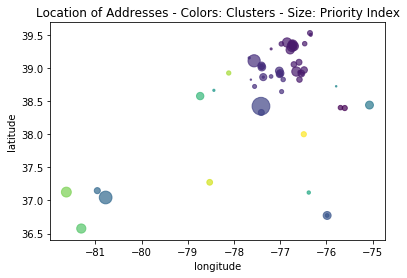

In [55]:
# Plot clusters, color coded for cluster, and size based on priority index
# Just for visualizing the location and severity of damages
plt.scatter(data=df_prio, 
            x='long', 
            y='lat', 
            c='cluster', 
            s=df_prio['priority_index']*15,
           alpha=0.7);

plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Location of Addresses - Colors: Clusters - Size: Priority Index');

### Sorting Addresses

In [56]:
# Get the order of clusters based on mean of prioritization score
cluster_prio = list(df_prio.groupby('cluster').mean()['priority_index'].sort_values(ascending=False).index)


In [57]:
# Showing cluster priority orders
cluster_prio

[4, 6, 13, 12, 7, 11, 2, 5, 3, 15, 16, 1, 14, 10, 9, 8]

In [58]:
# Create the dictionary that defines the order for sorting
cluster_prio_indexer = dict(zip(cluster_prio,range(len(cluster_prio))))

# Generate a rank column that will be used to sort the dataframe numerically
df_prio['cluster_ranked'] = df_prio['cluster'].map(cluster_prio_indexer)

In [59]:
# Sort the DF based on cluster_ranked (ascending), and then 
# priority_index (descending)
df_prio = df_prio.sort_values(by=['cluster_ranked', 'priority_index'], 
                    ascending=[True, False])



### Preparing No-Priority DataFrame for Concatination with Priority DataFrame

In [60]:
# Adding columns to math df_prio
df_no_prio['priority_index'] = 0
df_no_prio['cluster'] = 0
df_no_prio['cluster_ranked'] = 0

In [61]:
# Creating a new column as the ratio of app_estimate and est_home_value
df_no_prio['damage_ratio'] = df_no_prio['app_estimate'] / df_no_prio['est_home_value']

In [62]:
# Sorting based on damage_ratio
df_no_prio = df_no_prio.sort_values(by='damage_ratio', ascending=False)

In [63]:
df_no_prio.drop('damage_ratio', axis=1, inplace=True)

### Concatinating the two DataFrames

In [64]:
df = pd.concat([df_prio, df_no_prio])

In [66]:
df.head()

,index,address,lat,long,app_comment,damage,app_estimate,safe_to_live,utils_on,insured,est_home_value,priority_index,cluster,cluster_ranked
32,43,"2 Willow Ln,Stafford,MD,22554",38.423219,-77.416092,"Lorem ipsum dolor sit amet, consectetur adipis...",2,279000,2,3,2,318000,21.056604,4,0
39,52,"25 King Georges Grant,Fredericksburg,MD,22405",38.328619,-77.408354,"Lorem ipsum dolor sit amet, consectetur adipis...",1,264000,1,2,2,436000,2.422018,4,0
41,55,"25 Lexington Ave,Pulaski,MD,24301",37.044942,-80.778614,"Lorem ipsum dolor sit amet, consectetur adipis...",2,277000,1,3,2,307000,10.827362,6,1
37,50,"25 Golden Acres Ln,Bland,MD,24315",37.148221,-80.958985,"Lorem ipsum dolor sit amet, consectetur adipis...",2,65000,2,2,2,420000,2.476190,6,1
29,39,"4027 Baptist Valley Rd,Cedar Bluff,MD,24609",37.126434,-81.629221,"Lorem ipsum dolor sit amet, consectetur adipis...",3,176000,2,3,1,484000,6.545455,13,2


In [170]:
df.drop(columns=['index','cluster', 'cluster_ranked']).to_csv('./data/apps_sorted.csv',
                                                                             index=False)
